In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, f1_score, roc_auc_score, classification_report, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

#1. Feature Selection

In [ ]:
#Load dataset
data = pd.read_csv('/content/drive/MyDrive/Thiazole project/data_with_descriptors_1.csv')
data

,Unnamed: 0,Smiles,pChEMBL Value,Activity,MaxAbsEStateIndex,MaxEStateIndex,MinEStateIndex,SPS,MolWt,HeavyAtomMolWt,...,fr_NH0,fr_NH1,fr_Ndealkylation2,fr_amide,fr_benzene,fr_bicyclic,fr_ether,fr_halogen,fr_piperdine,fr_pyridine
0,0,Brc1ccc(OC[C@@H]2C[C@H]3C[C@H]3N2)cn1.Cl,7.330000,1,8.323890,8.323890,-3.530358,64.875000,305.603,291.491,...,1,1,0,0,0,1,1,2,1,1
1,1,Brc1cncc(OC[C@@H]2C[C@@H]3C[C@@H]3N2)c1.Cl,8.540000,1,8.331268,8.331268,-3.513776,64.875000,305.603,291.491,...,1,1,0,0,0,1,1,2,1,1
2,2,Brc1cncc(OC[C@@H]2C[C@H]3C[C@H]3N2)c1.O=C(O)C(...,8.190000,1,10.896164,10.896164,-3.513776,53.080000,419.228,400.076,...,1,1,0,0,0,1,1,1,1,1
3,3,C(#Cc1cncc(OC[C@@H]2CCN2)c1)c1ccccc1,10.310000,1,8.245222,8.245222,-3.515609,38.600000,264.328,248.200,...,1,1,0,0,1,0,1,0,0,1
4,4,C(#Cc1cncc(OC[C@H]2CCN2)c1)c1ccccc1,9.960000,1,8.245222,8.245222,-3.515609,38.600000,264.328,248.200,...,1,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,651,c1cncc(OCCN2CCCC2)c1,6.670000,0,8.029445,8.029445,-3.904855,50.285714,192.262,176.134,...,2,0,1,0,0,0,1,0,0,1
652,652,c1cncc(OC[C@@H]2CCN2)c1,10.346667,1,7.911737,7.911737,-3.367943,53.333333,164.208,152.112,...,1,1,0,0,0,0,1,0,0,1
653,653,c1cncc([C@@H]2CCCN2)c1,7.540000,1,8.249213,8.249213,-3.338776,61.818182,148.209,136.113,...,1,1,0,0,0,0,0,0,0,1
654,654,c1nc2cc3c(cc2[nH]1)C1CNCC3C1,9.820000,1,8.681182,8.681182,-3.330962,62.000000,199.257,186.153,...,1,2,0,0,1,6,0,0,1,0


In [ ]:
classify_data = data.drop(columns=['Unnamed: 0', 'Smiles', 'pChEMBL Value'])  # Remove unnecessary column
classify_data

,Activity,MaxAbsEStateIndex,MaxEStateIndex,MinEStateIndex,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,FpDensityMorgan3,...,fr_NH0,fr_NH1,fr_Ndealkylation2,fr_amide,fr_benzene,fr_bicyclic,fr_ether,fr_halogen,fr_piperdine,fr_pyridine
0,1,8.323890,8.323890,-3.530358,64.875000,305.603,291.491,303.997803,88,3.500000,...,1,1,0,0,0,1,1,2,1,1
1,1,8.331268,8.331268,-3.513776,64.875000,305.603,291.491,303.997803,88,3.500000,...,1,1,0,0,0,1,1,2,1,1
2,1,10.896164,10.896164,-3.513776,53.080000,419.228,400.076,418.037563,138,2.840000,...,1,1,0,0,0,1,1,1,1,1
3,1,8.245222,8.245222,-3.515609,38.600000,264.328,248.200,264.126263,100,3.150000,...,1,1,0,0,1,0,1,0,0,1
4,1,8.245222,8.245222,-3.515609,38.600000,264.328,248.200,264.126263,100,3.150000,...,1,1,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,0,8.029445,8.029445,-3.904855,50.285714,192.262,176.134,192.126263,76,3.357143,...,2,0,1,0,0,0,1,0,0,1
652,1,7.911737,7.911737,-3.367943,53.333333,164.208,152.112,164.094963,64,4.083333,...,1,1,0,0,0,0,1,0,0,1
653,1,8.249213,8.249213,-3.338776,61.818182,148.209,136.113,148.100048,58,3.818182,...,1,1,0,0,0,0,0,0,0,1
654,1,8.681182,8.681182,-3.330962,62.000000,199.257,186.153,199.110947,76,3.133333,...,1,2,0,0,1,6,0,0,1,0


In [ ]:
#Split into train and test set

X = classify_data.drop(columns=['Activity'])  # All descriptors
y = classify_data['Activity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


<ipython-input-6-702f09007a76>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Blues")
<ipython-input-6-702f09007a76>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Greens")


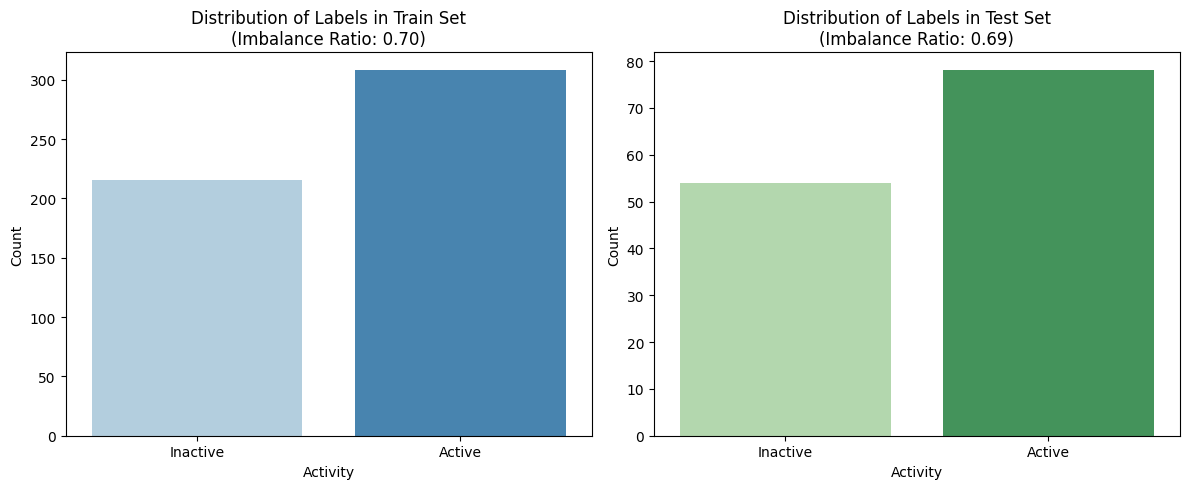

In [ ]:
# Plot distribution of labels in train and test sets
plt.figure(figsize=(12, 5))

# Train set distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="Blues")
train_counts = y_train.value_counts()
train_ratio = train_counts[0] / train_counts[1] if 0 in train_counts.index else np.nan
plt.title(f"Distribution of Labels in Train Set\n(Imbalance Ratio: {train_ratio:.2f})")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks([0, 1], ['Inactive', 'Active'])

# Test set distribution
plt.subplot(1, 2, 2)
sns.countplot(x=y_test, palette="Greens")
test_counts = y_test.value_counts()
test_ratio = test_counts[0] / test_counts[1] if 0 in test_counts.index else np.nan
plt.title(f"Distribution of Labels in Test Set\n(Imbalance Ratio: {test_ratio:.2f})")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks([0, 1], ['Inactive', 'Active'])

plt.tight_layout()
plt.show()


In [ ]:
#Feature Selection using Random Forest
rf = RandomForestClassifier(
    n_estimators=200,          # Increase the number of trees to improve accuracy
    max_depth=10,              # Limit the depth of each tree
    min_samples_split=5,       # Minimum number of samples required to split an internal node
    min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
    max_features='sqrt',       # Number of features to consider when looking for the best split
    class_weight='balanced',   # Handle class imbalance by adjusting weights
    random_state=42            # Ensure reproducibility
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
#Select features based on feature importance threshold
selector = SelectFromModel(rf, threshold=0.015, prefit=True)
X_train_selected = selector.transform(X_train)
selected_features = X.columns[selector.get_support()]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


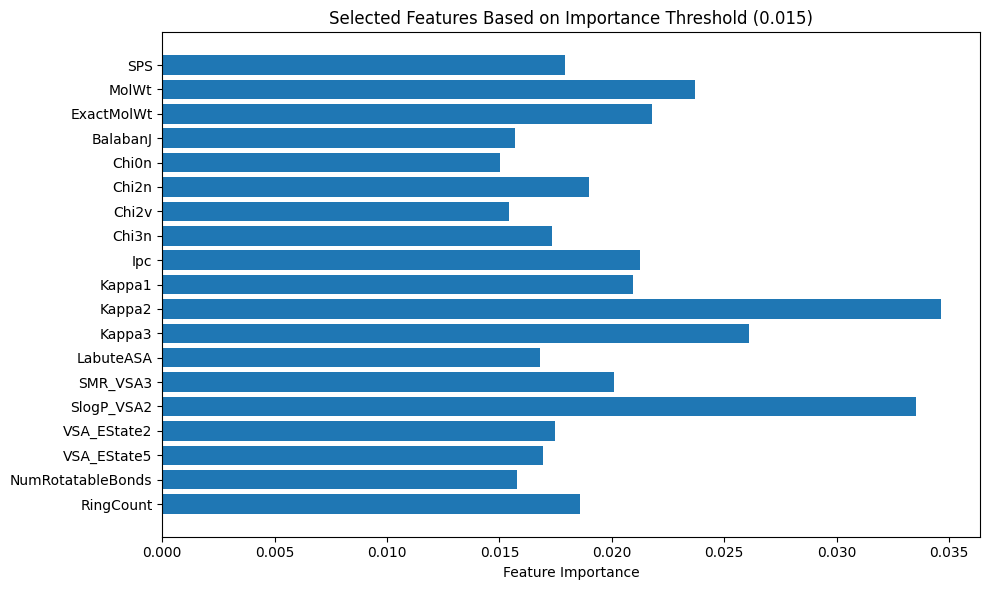

In [ ]:
# Plot feature importances for the selected features
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort indices by importance in descending order
selected_importances = importances[selector.get_support()]  # Importances of selected features

plt.figure(figsize=(10, 6))
plt.barh(range(len(selected_features)), selected_importances[::-1], align='center')
plt.yticks(range(len(selected_features)), selected_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Selected Features Based on Importance Threshold (0.015)")
plt.tight_layout()
plt.show()


In [ ]:
# Output selected features
print("Selected Features:", selected_features.tolist())
print(f"Number of Selected Features: {len(selected_features)}")


Selected Features: ['SPS', 'MolWt', 'ExactMolWt', 'BalabanJ', 'Chi0n', 'Chi2n', 'Chi2v', 'Chi3n', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'SMR_VSA3', 'SlogP_VSA2', 'VSA_EState2', 'VSA_EState5', 'NumRotatableBonds', 'RingCount']
Number of Selected Features: 19


In [ ]:
# Apply the selected features to the test set
X_test_selected = X_test[selected_features]
X_test_selected

,SPS,MolWt,ExactMolWt,BalabanJ,Chi0n,Chi2n,Chi2v,Chi3n,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,SMR_VSA3,SlogP_VSA2,VSA_EState2,VSA_EState5,NumRotatableBonds,RingCount
51,36.277778,250.342,250.168128,3.937512,30.710924,2.588066,2.588066,1.424365,3.344501e+07,2.656013,7.011478,4.372750,140.055026,4.899910,44.497508,11.242158,0.000000,9,1
614,56.111111,235.330,235.136100,2.388214,25.947214,3.710410,3.710410,2.710410,1.994093e+07,2.935503,3.959214,1.438270,131.793963,5.309813,12.993719,0.000000,-6.727119,1,4
385,58.304348,316.380,316.169940,2.056693,32.075067,4.108823,4.108823,2.728224,6.948163e+08,4.169570,6.275815,2.950866,164.099944,19.893780,52.570038,-0.542994,-5.429485,5,5
637,57.076923,345.446,345.184112,1.988412,35.749889,4.939783,4.939783,3.335789,9.264381e+09,4.682134,6.689166,2.946014,185.705033,14.867867,39.959497,6.391751,-5.862694,4,6
132,52.933333,201.269,201.115364,2.585501,22.355462,2.829069,2.829069,1.967265,1.514381e+06,2.352263,3.384743,1.365369,110.560668,4.899910,18.372596,-0.322799,0.000000,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,33.083333,162.236,162.115698,3.625987,19.894427,1.559017,1.559017,0.828812,1.467235e+05,1.704706,5.493967,3.302755,93.063664,10.293792,18.456665,3.290694,0.000000,5,1
231,68.437500,240.734,240.102941,0.000002,24.680640,2.914479,2.914479,1.823164,4.402971e+06,2.780636,4.224793,2.154169,125.694875,10.293792,24.272480,3.267864,-4.330556,4,3
177,82.500000,170.212,170.105528,2.807997,19.710924,2.012397,2.012397,1.302508,1.211897e+05,1.708183,2.935678,1.158518,91.594590,10.209723,44.018541,11.514751,-7.370017,1,2
142,45.000000,270.332,270.136828,2.243329,27.710924,3.484616,3.484616,2.213955,4.005067e+07,3.628593,5.588494,2.652068,143.205849,9.883888,41.902758,15.865072,-2.006712,4,3


#2. Training Random Forest Classification Model

In [ ]:
#Train Random Forest model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_selected, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
#Cross Validation
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores_f1_rf_baseline = cross_val_score(model, X_train_selected, y_train, scoring = "f1", cv=cv, n_jobs = 1)
scores_ap_rf_baseline=cross_val_score(model, X_train_selected, y_train, scoring = "average_precision",
                         cv= cv, n_jobs = 1)
scores_accuracy_rf_baseline = cross_val_score(model, X_train_selected, y_train, scoring = "accuracy",
                         cv= cv, n_jobs = 1)
f1 = scores_f1_rf_baseline.mean()
ap = scores_ap_rf_baseline.mean()
accuracy = scores_accuracy_rf_baseline.mean()
print("accuracy cross validation", accuracy, "+/-",round(scores_accuracy_rf_baseline.std(),4))
print("f1 cross validation", f1, "+/-",round(scores_f1_rf_baseline.std(),4))
print("ap validation", ap, "+/-",round(scores_ap_rf_baseline.std(),4))

accuracy cross validation 0.8244799225931302 +/- 0.0518
f1 cross validation 0.8556823213192134 +/- 0.043
ap validation 0.9124674752743225 +/- 0.0367


In [ ]:
# Final evaluation on test set using the trained model
y_pred = model.predict(X_test_selected)

# Calculate test set metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred)

# Print test set metrics

print(f"Test Set Accuracy: {accuracy:.2f}")
print(f"Test Set Precision: {precision:.2f}")
print(f"Test Set Recall: {recall:.2f}")
print(f"Test Set F1-Score: {f1:.2f}")
print(f"Test Set AP: {ap:.2f}")



Test Set Accuracy: 0.83
Test Set Precision: 0.81
Test Set Recall: 0.92
Test Set F1-Score: 0.86
Test Set AP: 0.79


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.69      0.76        54
           1       0.81      0.92      0.86        78

    accuracy                           0.83       132
   macro avg       0.83      0.80      0.81       132
weighted avg       0.83      0.83      0.82       132



In [ ]:
print('AUC =', roc_auc_score(y_test, model.predict(X_test_selected)))
print('AP =', average_precision_score(y_test, model.predict(X_test_selected)))

AUC = 0.8041310541310541
AP = 0.7922134045729551


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


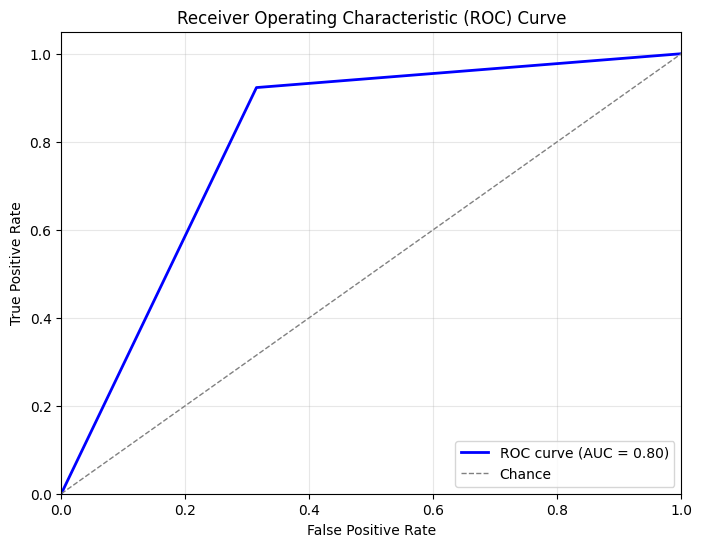

In [ ]:
# Calculate ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

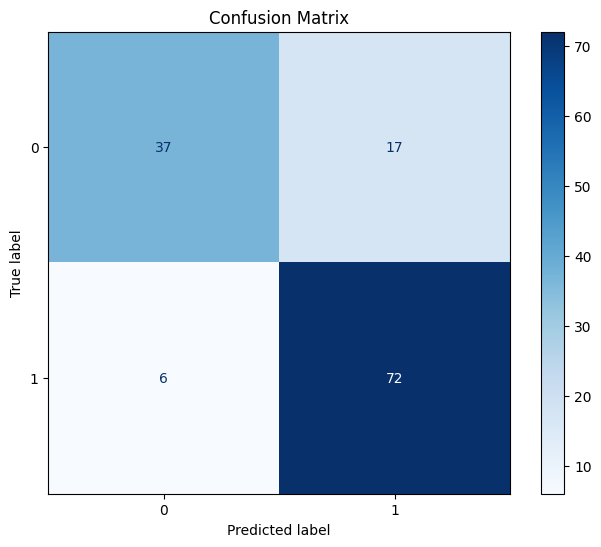

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# Display confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
plt.title("Confusion Matrix")

plt.show()

##2.1. Hyperparameter tuning

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import make_scorer
from optuna.trial import TrialState
from optuna.samplers import TPESampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
# Objective function for optimization
def objective(trial):
    # Define hyperparameter search space
    ratio = trial.suggest_float("sampling_strategy", 0.5,1)
    sampling = SMOTE(random_state=42,sampling_strategy =ratio)
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 10, 100)



    # Define the model
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        max_leaf_nodes=max_leaf_nodes
    )
    steps = [('s', sampling),('m', rf)]
    pipeline = Pipeline(steps = steps)
    # Calculate F1-Score using Cross-Validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    f1_rf_best = cross_val_score(rf, X_train_selected, y_train, cv=cv, scoring=make_scorer(f1_score)).mean()
    return f1_rf_best



sampler = TPESampler(seed = 42)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=300)

# Print the best hyperparameters and the corresponding score
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2024-12-31 14:19:20,486] A new study created in memory with name: no-name-a5e980d8-7232-4ac0-86d3-01daf60f0fb7
[I 2024-12-31 14:20:44,483] Trial 0 finished with value: 0.8547325936585826 and parameters: {'sampling_strategy': 0.6872700594236812, 'n_estimators': 954, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_leaf_nodes': 24}. Best is trial 0 with value: 0.8547325936585826.
[I 2024-12-31 14:22:03,822] Trial 1 finished with value: 0.8554162686847583 and parameters: {'sampling_strategy': 0.5290418060840998, 'n_estimators': 873, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_leaf_nodes': 98}. Best is trial 1 with value: 0.8554162686847583.
[I 2024-12-31 14:22:33,581] Trial 2 finished with value: 0.8580937677081002 and parameters: {'sampling_strategy': 0.9162213204002109, 'n_estimators': 251, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_leaf_nodes': 57}. Best is trial 2 with value: 0.8580937677081002.
[I 2024-12-31 14:

Best Parameters: {'sampling_strategy': 0.683239332620699, 'n_estimators': 792, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_leaf_nodes': 10}
Best Score: 0.8673632398237264


##2.2. Train Optimized Model

In [ ]:
# Calculate minority class ratio in y_train
minority_class_ratio = y_train.value_counts(normalize=True).min()

# Print the ratio
print(f"Minority Class Ratio in Training Data: {minority_class_ratio:.2f}")

Minority Class Ratio in Training Data: 0.41


In [ ]:
rf_model_opt = RandomForestClassifier(
    n_estimators=792,
    max_depth=5,
    min_samples_split=6,
    min_samples_leaf=4,
    max_leaf_nodes=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
sampling = SMOTE(random_state=42,sampling_strategy =0.8)
steps = [('s', sampling),('m', rf_model_opt)]
pipeline = Pipeline(steps = steps)
pipeline.fit(X_train_selected,y_train)
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores_accuracy_rf_opt = cross_val_score(pipeline, X_train_selected, y_train, scoring = "accuracy", cv=cv, n_jobs = 10)
scores_f1_rf_opt = cross_val_score(pipeline, X_train_selected, y_train, scoring = "f1", cv=cv, n_jobs = 10)
scores_ap_rf_opt=cross_val_score(pipeline, X_train_selected, y_train, scoring = "average_precision",
                        cv= cv, n_jobs = 10)
accuracy_rf_opt = scores_accuracy_rf_opt.mean()
ap_rf_opt = scores_ap_rf_opt.mean()
f1_rf_opt = scores_f1_rf_opt.mean()
print("accuracy cross validation", f1, "+/-",round(scores_accuracy_rf_opt.std(),4))
print("ap validation", ap, "+/-",round(scores_ap_rf_opt.std(),4))
print("f1 cross validation", f1, "+/-",round(scores_f1_rf_opt.std(),4))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sk

accuracy cross validation 0.8622754491017964 +/- 0.0524
ap validation 0.7922134045729551 +/- 0.0384
f1 cross validation 0.8622754491017964 +/- 0.0419


In [ ]:
y_test_pred = rf_model_opt.predict(X_test_selected)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73        54
           1       0.78      0.94      0.85        78

    accuracy                           0.81       132
   macro avg       0.83      0.78      0.79       132
weighted avg       0.82      0.81      0.80       132



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
ap_opt = average_precision_score(y_test, y_test_pred)
accuracy_opt = accuracy_score(y_test, y_test_pred)
f1_opt = f1_score(y_test, y_test_pred)
print('AP =', ap_opt)
print('Accuracy =', accuracy_opt)
print('F1 =', f1_opt)

AP = 0.7725079579918289
Accuracy = 0.8106060606060606
F1 = 0.8538011695906432


In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[34, 20],
       [ 5, 73]])

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), SVC(kernel='poly', random_state=42))
clf.fit(X_train_selected,y_train)
predictions = clf.predict(X_test_selected)
accuracy_score(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



0.75

#3. Train GradientBoosting Model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#Define model GradientBoosting
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
gb_model.fit(X_train_selected, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores_f1_gb = cross_val_score(gb_model, X_train_selected, y_train, scoring = "f1", cv=cv, n_jobs = 1)
scores_ap_gb=cross_val_score(gb_model, X_train_selected, y_train, scoring = "average_precision",
                         cv= cv, n_jobs = 1)
scores_accuracy_gb = cross_val_score(gb_model, X_train_selected, y_train, scoring = "accuracy",
                         cv= cv, n_jobs = 1)
f1_gb = scores_f1_gb.mean()
ap_gb = scores_ap_gb.mean()
accuracy_gb = scores_accuracy_gb.mean()
print("accuracy cross validation of", accuracy_gb, "+/-",round(scores_accuracy_gb.std(),4))
print("f1 cross validation", f1_gb, "+/-",round(scores_f1_gb.std(),4))
print("ap validation", ap_gb, "+/-",round(scores_ap_gb.std(),4))

accuracy cross validation of 0.8200774068698596 +/- 0.0549
f1 cross validation 0.8506872404998003 +/- 0.0458
ap validation 0.9036938039710968 +/- 0.0458


In [ ]:
y_pred_gb = gb_model.predict(X_test_selected)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.86      0.70      0.78        54
           1       0.82      0.92      0.87        78

    accuracy                           0.83       132
   macro avg       0.84      0.81      0.82       132
weighted avg       0.84      0.83      0.83       132



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [ ]:
ap_test_gb = average_precision_score(y_test, y_pred_gb)
accuracy_test_gb = accuracy_score(y_test, y_pred_gb)
f1_test_gb = f1_score(y_test, y_pred_gb)
recall_test_gb = recall_score(y_test, y_pred_gb)
precision_test_gb = precision_score(y_test, y_pred_gb)
auc_test_gb = roc_auc_score(y_test, y_pred_gb)
print('AP of Test set =', ap_test_gb)
print('Accuracy of Test set =', accuracy_test_gb)
print('F1 of Test set =', f1_test_gb)
print('Recall of Test set =', recall_test_gb)
print('Precision of Test set =', precision_test_gb)
print('AUC of Test set =', auc_test_gb)


AP of Test set = 0.8006993006993007
Accuracy of Test set = 0.8333333333333334
F1 of Test set = 0.8674698795180723
Recall of Test set = 0.9230769230769231
Precision of Test set = 0.8181818181818182
AUC of Test set = 0.8133903133903135


In [ ]:
cm2=confusion_matrix(y_test, y_pred_gb)
cm2

array([[38, 16],
       [ 6, 72]])

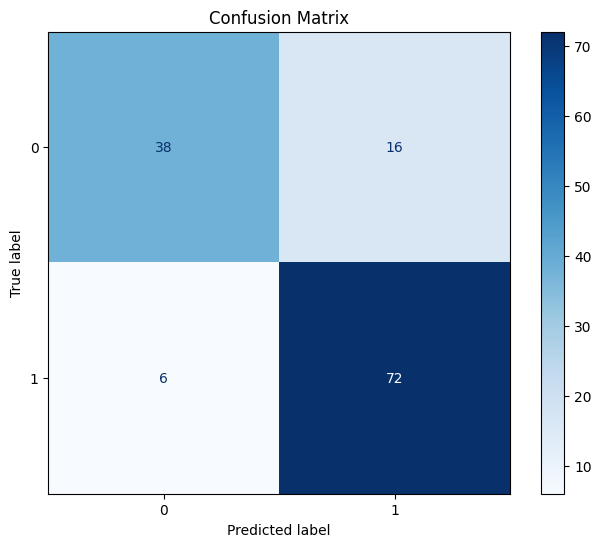

In [ ]:
# Display confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
plt.title("Confusion Matrix")

plt.show()

##3.1. Hyperparameter tuning for GradientBoosting model

In [ ]:
from optuna.trial import TrialState
from optuna.samplers import TPESampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [ ]:
# Hàm mục tiêu để tối ưu hóa hyperparameters
def objective(trial):
    ratio = trial.suggest_float("sampling_strategy", 0.5,1)
    sampling = SMOTE(random_state=42,sampling_strategy =ratio)
    # Định nghĩa không gian tìm kiếm cho các tham số
    n_estimators = trial.suggest_int('n_estimators', 50, 300)  # Số lượng cây
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)  # Tốc độ học
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Độ sâu tối đa
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Số mẫu tối thiểu để chia
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Số mẫu tối thiểu ở nút lá
    subsample = trial.suggest_float('subsample', 0.6, 1.0)  # Tỷ lệ dữ liệu sử dụng trong mỗi cây

    # Khởi tạo mô hình Gradient Boosting với tham số hiện tại
    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )
    steps = [('s', sampling),('m', gb)]
    pipeline = Pipeline(steps = steps)
    # Tính F1-Score qua Cross-Validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv_f1_gb = cross_val_score(
        gb, X_train_selected, y_train,
        cv=cv, scoring=make_scorer(f1_score)
    ).mean()

    return cv_f1_gb  # Trả về kết quả F1-Score

# Khởi tạo Optuna study
sampler = TPESampler(seed = 42)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=-1)

# In ra kết quả tối ưu
print("Best Parameters:", study.best_params)
print("Best f1 Score:", study.best_value)

[I 2024-12-31 09:32:21,671] A new study created in memory with name: no-name-b194ab9a-e29b-4b0b-a17f-a0d9ed8a09ff
[I 2024-12-31 09:33:43,317] Trial 1 finished with value: 0.8373801948392094 and parameters: {'sampling_strategy': 0.9296962417806813, 'n_estimators': 196, 'learning_rate': 0.2985689617903021, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1, 'subsample': 0.8729653049644666}. Best is trial 1 with value: 0.8373801948392094.
[I 2024-12-31 09:34:28,984] Trial 0 finished with value: 0.8513029318821759 and parameters: {'sampling_strategy': 0.5662689228501998, 'n_estimators': 284, 'learning_rate': 0.017641555101897268, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.6647388536782277}. Best is trial 0 with value: 0.8513029318821759.
[I 2024-12-31 09:35:23,990] Trial 2 finished with value: 0.850355069442693 and parameters: {'sampling_strategy': 0.9063113916093082, 'n_estimators': 203, 'learning_rate': 0.02561070199552297, 'max_depth': 10, '

KeyboardInterrupt: 

##3.2. Train optimized GradientBoosting model

In [ ]:
gb_model_opt = GradientBoostingClassifier(
    n_estimators=65,
    learning_rate=0.012308078909981179,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.6631661061649494,
    random_state=42
)
sampling = SMOTE(random_state=42,sampling_strategy =0.858953601774149)
steps = [('s', sampling),('m', gb_model_opt)]
pipeline = Pipeline(steps = steps)
pipeline.fit(X_train_selected,y_train)
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores_accuracy_opt = cross_val_score(pipeline, X_train_selected, y_train, scoring = "f1", cv=cv, n_jobs = 10)
scores_ap_opt=cross_val_score(pipeline, X_train_selected, y_train, scoring = "average_precision",
                        cv= cv, n_jobs = 10)
accuracy_opt_gb = scores_accuracy_opt.mean()
ap = scores_ap_opt.mean()
print("accuracy cross validation", f1, "+/-",round(scores_accuracy_opt.std(),4))
print("ap validation", ap, "+/-",round(scores_ap_opt.std(),4))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning:

The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning:

The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inhe

accuracy cross validation 0.8557136013250191 +/- 0.0445
ap validation 0.9213767752621387 +/- 0.0347


In [ ]:
y_pred_opt = pipeline.predict(X_test)
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80        54
           1       0.83      0.95      0.89        78

    accuracy                           0.86       132
   macro avg       0.87      0.84      0.85       132
weighted avg       0.86      0.86      0.85       132

